In [13]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch

import pandas as pd
import time
import os
import shutil
#sns.set(color_codes=True)

# load data
tmp_dir = "./tmp_csv/"
#years = [str(year) for year in range(1994,2009)]
years = [str(year) for year in range(2004,2006)]
years

['2004', '2005']

## Procesar datos

In [21]:
#crear directorio con data de delays agrupada por retraso 

# tipos de cancelamiento
CCarrier  = "A"
CWeather  = "B"
CNAS      = "C"
CSecurity = "D"

# frequency = 'D' (diario) o 'M' (mensual)
def create_grouped_files(subdir, years, frequency):
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

    if not os.path.exists(tmp_dir + subdir):
        os.makedirs(tmp_dir + subdir)
    else:
        return

    df_cut = pd.DataFrame(columns=["date", "ArrDelay"]).set_index("date")
    df_full = pd.DataFrame(columns=["date", "ArrDelay"]).set_index("date")
    for year in years:
        if not os.path.exists(tmp_dir+subdir+year+".csv"):
            print("Leyendo csv: {}".format(year))
            df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                             usecols=["Month", "Year", "DayofMonth", "DayOfWeek"] \
                                     + ["ArrDelay", "DepDelay", "WeatherDelay", "CarrierDelay"] \
                                     + ["Cancelled", "CancellationCode"]
                                     + ["NASDelay", "LateAircraftDelay"], \
                             encoding="ISO 8859-1")

            #formato mas feliz para fechas
            dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth, format='%Y%m%d')
            df["date"] = dates

            #acumulamos en full antes de recortar outliers
            df_cancell = df[["date", "Cancelled", "CancellationCode"]]
            df = df[["date", "ArrDelay"]]

            dg = df.groupby(pd.Grouper(key='date', freq=frequency)).mean()
            df_full = pd.concat([df_full, dg], sort=False)

            #sacamos outliers, nos quedamos con el 80% per bucket
            low = 0.1
            high = 0.9
            qiles = df.groupby(pd.Grouper(key='date', freq=frequency))["ArrDelay"].quantile([low, high]).unstack(level=1)
            mask =  (qiles.loc[df.date, low] < df.ArrDelay.values) & \
                    (df.ArrDelay.values < qiles.loc[df.date, high])
            df = df.loc[mask.values]

            #agrupamos
            df_delay   = df.groupby(by=df['date'].dt.date).mean()
            # que las cancelaciones no sean por clima o seguridad
            df_cancell = df_cancell[(df_cancell['CancellationCode'] != CSecurity) & (df_cancell['CancellationCode'] != CWeather)]
            df_cancell = df_cancell.groupby(by=df_cancell['date'].dt.date)['Cancelled'].sum()

            df_delay.to_csv(tmp_dir+subdir+year+".csv")
            df_cancell.to_csv(tmp_dir+subdir+year+"_cancelled.csv")

            df_cut = pd.concat([df_cut, df_delay], sort=False)
            del df_delay
            del df_cancell

    df_cut.to_csv(tmp_dir+subdir+"cut"+".csv")
    df_full.to_csv(tmp_dir+subdir+"full"+".csv")

create_grouped_files("daily/", years, 'D')
print("Listo ./tmp_csv/daily/")
create_grouped_files("monthly/", years, 'M')
print("Listo ./tmp_csv/monthly/")

Listo ./tmp_csv/daily/
Listo ./tmp_csv/monthly/


2004.csv


AttributeError: 'DataFrame' object has no attribute 'date'

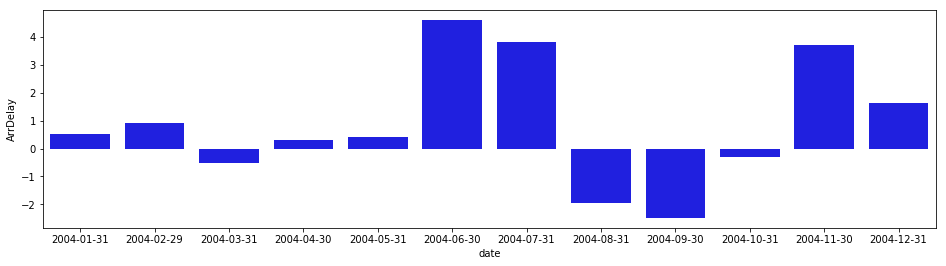

AttributeError: 'DataFrame' object has no attribute 'date'

In [22]:
for filename in sorted(os.listdir(tmp_dir+"monthly/")):
    if filename.endswith(".csv") and not filename.endswith("_cancelled.csv") and filename not in ["cut.csv", "full.csv"]:
        print(filename)
        df_delay   = pd.read_csv(tmp_dir+"monthly/"+filename)
        df_cancell = pd.read_csv(tmp_dir+"monthly/"+filename.split(".")[0]+"_cancelled.csv")

        fig, ax = plt.subplots(figsize=(16,4))

        sns.barplot(x=df_delay.date, y=df_delay.ArrDelay, color="blue")
        sns.barplot(x=df_cancell.date, y=df_cancell.Cancelled, secondary_y=True, color="red")

        plt.xticks(plt.xticks()[0], df_delay.date, rotation=90)
        plt.tight_layout()
        xticks = ax.xaxis.get_major_ticks()
        for i in range(len(xticks)):
            """
            if i%1 != 0:
                xticks[i].set_visible(True)
            """
            if i%int((len(xticks))/4) == 0:
                plt.axvline(x=i, color="orange")
            if i%int((len(xticks))/3) == 0:
                plt.axvline(x=i, color="green")
        fig.autofmt_xdate()
        plt.show()

#Trimestres en verde, cuatrimestres en naranja

            date   ArrDelay
0     1994-01-01   0.294359
1     1994-01-02   5.543427
2     1994-01-03   8.508602
3     1994-01-04   8.007037
4     1994-01-05   9.983885
5     1994-01-06  10.062159
6     1994-01-07   6.081060
7     1994-01-08   1.972373
8     1994-01-09   3.201787
9     1994-01-10   2.996256
10    1994-01-11   3.272031
11    1994-01-12  10.122388
12    1994-01-13   5.920019
13    1994-01-14   6.015333
14    1994-01-15   0.124765
15    1994-01-16   7.362417
16    1994-01-17  12.512040
17    1994-01-18   8.728511
18    1994-01-19   8.344899
19    1994-01-20   8.517387
20    1994-01-21   3.420623
21    1994-01-22  -0.967485
22    1994-01-23   0.647347
23    1994-01-24   2.026228
24    1994-01-25   4.581582
25    1994-01-26  11.314592
26    1994-01-27  17.260879
27    1994-01-28  14.354249
28    1994-01-29   2.277312
29    1994-01-30   5.941826
...          ...        ...
5448  2008-12-02  -0.005257
5449  2008-12-03  -1.129011
5450  2008-12-04   0.207976
5451  2008-12-05  -2

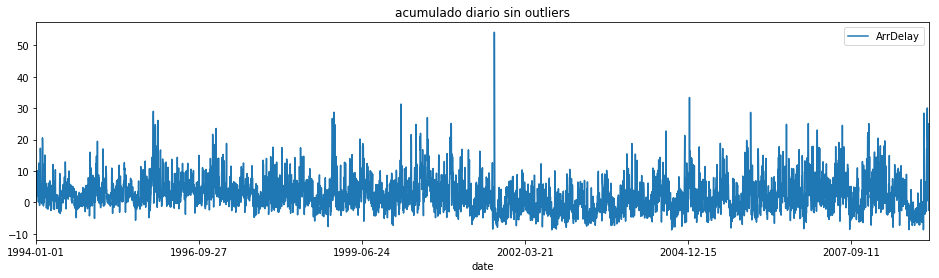

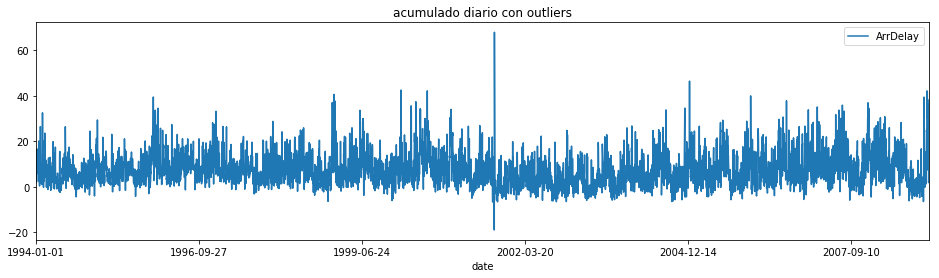

In [4]:
df_daily_cut = pd.read_csv(tmp_dir+"daily/cut.csv")
print(df_daily_cut)
df_daily_cut.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado diario sin outliers")

df_daily_full = pd.read_csv(tmp_dir+"daily/full.csv")
df_daily_full.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado diario con outliers")

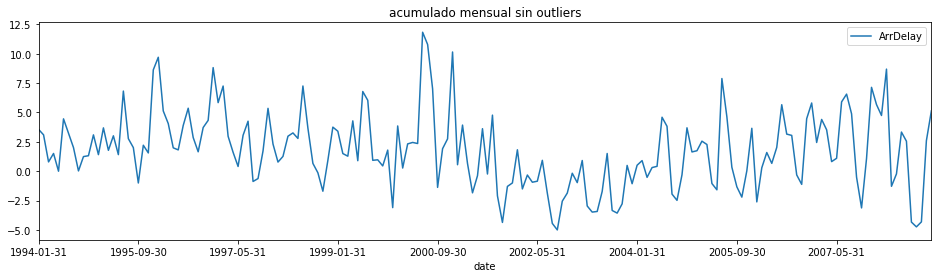

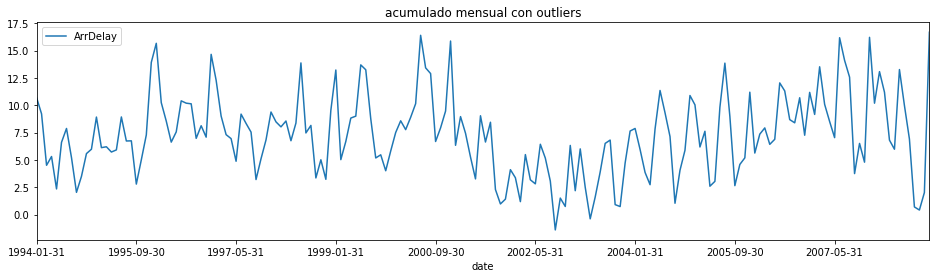

In [5]:
df_monthly_cut = pd.read_csv(tmp_dir+"monthly/cut.csv")
df_monthly_cut.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado mensual sin outliers")

df_monthly_full = pd.read_csv(tmp_dir+"monthly/full.csv")
df_monthly_full.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado mensual con outliers")

# CML acá 
## Diario

In [6]:
del df
df = pd.read_csv(tmp_dir+"daily/full.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.sort_values(by="date")

year_train_limit = 2007
lower_year_train_limit = 1994

train_delays = df.loc[(df["date"].dt.year < year_train_limit) & \
                      (df["date"].dt.year > lower_year_train_limit)]["ArrDelay"]
print(len(train_delays))
print(len(df["ArrDelay"]))

4383
5479


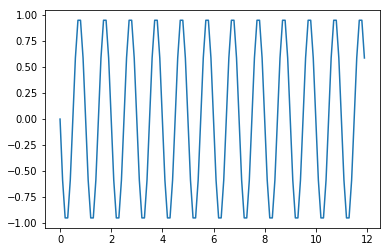

In [7]:
#para jugar con fases
import numpy as np
import math

time        = np.arange(0, 12, 0.1);
amplitude   = np.sin(2 * math.pi / 1* time + math.pi)
plt.plot(time, amplitude)
plt.show()

In [8]:

max_grade = 1
phases = [i*math.pi/2 for i in range(4)]
monthly_freqs =  [3, 4, 6, 12]
# semanas, meses, bimestres, trimestres, cuatrimestres, semestres, años
daily_freqs =  [7] + [355/i for i in [12, 6, 4, 3, 2, 1]] 

class lsqPredictor:
    def __init__(self, phases, freqs, max_grade):
        self.phases = phases
        self.freqs = freqs
        self.max_grade = max_grade
    
    def trig_vals(self, t):
        return  [math.sin(2 * math.pi / f * t + p) for f in self.freqs for p in self.phases]

    def get_x_vals(self, x):
        x_vals = []
        for i in range(len(x)):
            row = np.array([i**p for p in range(self.max_grade+1)] + self.trig_vals(i), dtype='float')
            x_vals.append(row)
        return x_vals
    
    def print_coefs(self):
        c = 0
        for i in range(self.max_grade+1):
            print("Coef de x^{}:\n{}".format(i, self.coefs[c]))
            c += 1
        for i in self.freqs:
            for j in self.phases:
                print("Coef de sinusoide con frecuencia {} y fase {}:\n{}".format(i, j, self.coefs[c]))
                c += 1
                
    def fit(self, train_set):
        arrays = self.get_x_vals(train_set)
        A = np.stack(arrays)
        self.coefs = np.linalg.solve(A.T@A, A.T@train_set)
    
    def pred(self, pred_set):
        arrays = self.get_x_vals(pred_set)
        full_A = np.stack(arrays)        
        return full_A@self.coefs 
    
lpr = lsqPredictor(phases, daily_freqs, max_grade)
lpr.fit(train_delays)
lpr.print_coefs()

Coef de x^0:
8.181951667917401
Coef de x^1:
-0.0005154969359443589
Coef de sinusoide con frecuencia 7 y fase 0.0:
50.48808131860838
Coef de sinusoide con frecuencia 7 y fase 1.5707963267948966:
-45.801542885158426
Coef de sinusoide con frecuencia 7 y fase 3.141592653589793:
51.326092283013125
Coef de sinusoide con frecuencia 7 y fase 4.71238898038469:
-44.50176965632156
Coef de sinusoide con frecuencia 29.583333333333332 y fase 0.0:
-351.7428657858814
Coef de sinusoide con frecuencia 29.583333333333332 y fase 1.5707963267948966:
-835.6385649065343
Coef de sinusoide con frecuencia 29.583333333333332 y fase 3.141592653589793:
-351.90085495999944
Coef de sinusoide con frecuencia 29.583333333333332 y fase 4.71238898038469:
-835.4094368340943
Coef de sinusoide con frecuencia 59.166666666666664 y fase 0.0:
-178.1305295687119
Coef de sinusoide con frecuencia 59.166666666666664 y fase 1.5707963267948966:
-19.896596499796924
Coef de sinusoide con frecuencia 59.166666666666664 y fase 3.141592653

In [9]:
if "dl_pred" in df:
    del df["dl_pred"]

In [10]:
train_test_delays = df["ArrDelay"]

df["dl_pred"] = lpr.pred(train_test_delays) 
df.describe()

,ArrDelay,dl_pred
count,5479.000000,5479.000000
mean,7.241327,6.773049
std,7.327431,1.590079
min,-19.000000,2.103281
25%,2.095552,5.650404
50%,5.977256,6.804066
75%,10.878614,7.922866
max,67.904927,10.821473


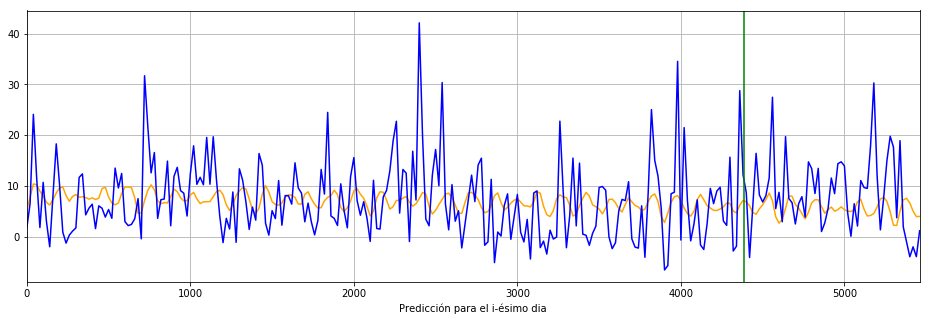

In [11]:
#df.plot(x="date", y=["DepDelay", "dl_pred"], figsize=(16,5))

def plot_df(df1, df2, train_limit_axis, unit_str):
    plt.figure(figsize=(16,5))
    plt.xlabel('Predicción para el i-ésimo {}'.format(unit_str))

    df2 = df2[df2.index % 20 == 0] 
    df1 = df1[df1.index % 20 == 0] 
    
    ax1 = df1.dl_pred.plot(color='orange', grid=True, label='pred delay')
    df2.ArrDelay.plot(color='blue', grid=True, secondary_y=False, label='real delay', ax=ax1)

    xticks = ax1.xaxis.get_major_ticks()
    plt.axvline(x=train_limit_axis, color="green")
    plt.show()

df_full = pd.read_csv(tmp_dir+"daily/full.csv")
df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
plot_df(df, df_full, len(train_delays), "dia")

In [12]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(df.loc[df["date"].dt.year>year_train_limit].dl_pred, df_full.loc[df_full["date"].dt.year>year_train_limit].ArrDelay))

9.719941853930601

## Mensual

In [13]:
del df
df = pd.read_csv(tmp_dir+"monthly/full.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.sort_values(by="date")
year_train_limit = 2002
lower_year_train_limit = 1994
train_delays = df.loc[(df["date"].dt.year < year_train_limit) & \
                      (df["date"].dt.year > lower_year_train_limit)]["ArrDelay"]

lpr = lsqPredictor(phases, monthly_freqs, max_grade)
lpr.fit(train_delays)
lpr.print_coefs()

Coef de x^0:
8.31047464627757
Coef de x^1:
-0.008029645015672349
Coef de sinusoide con frecuencia 3 y fase 0.0:
-16.426213515622713
Coef de sinusoide con frecuencia 3 y fase 1.5707963267948966:
-5.224650776211153
Coef de sinusoide con frecuencia 3 y fase 3.141592653589793:
-15.788143084743695
Coef de sinusoide con frecuencia 3 y fase 4.71238898038469:
-5.280029187756231
Coef de sinusoide con frecuencia 4 y fase 0.0:
-81.7913417972578
Coef de sinusoide con frecuencia 4 y fase 1.5707963267948966:
-10.341026412081519
Coef de sinusoide con frecuencia 4 y fase 3.141592653589793:
-81.54746784557136
Coef de sinusoide con frecuencia 4 y fase 4.71238898038469:
-10.1940255593611
Coef de sinusoide con frecuencia 6 y fase 0.0:
1.2212445031447454
Coef de sinusoide con frecuencia 6 y fase 1.5707963267948966:
7.277262230578698
Coef de sinusoide con frecuencia 6 y fase 3.141592653589793:
2.093485602307705
Coef de sinusoide con frecuencia 6 y fase 4.71238898038469:
4.837209302325581
Coef de sinusoide c

In [14]:
if "dl_pred" in df:
    del df["dl_pred"]

In [15]:
train_test_delays = df["ArrDelay"]

df["dl_pred"] = lpr.pred(train_test_delays) 

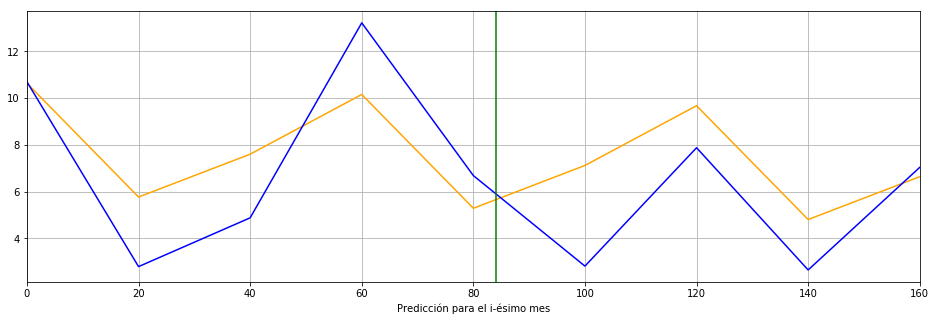

In [16]:
df_full = pd.read_csv(tmp_dir+"monthly/full.csv")
df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
plot_df(df, df_full, len(train_delays), "mes")

In [17]:
math.sqrt(mean_squared_error(df.loc[df["date"].dt.year>year_train_limit].dl_pred, df_full.loc[df_full["date"].dt.year>year_train_limit].ArrDelay))

3.369635444404274

## BORRAR ARCHIVOS

In [18]:
#borrar aux de años
#for filename in os.listdir(tmp_dir):
#    if fnmatch.fnmatch(filename, '*.csv') and filename != "merged.csv":
#        os.remove(tmp_dir+filename)

In [19]:
#borrar merged
os.remove(tmp_dir+"merged.csv")

FileNotFoundError: [Errno 2] No such file or directory: './tmp_csv/merged.csv'

In [ ]:
#borrar tmp
#shutil.rmtree(tmp_dir)